In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import gc
import pickle
from tqdm import tqdm
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

print("AutoML version:", AutoML.__version__)

AutoML version: 2.1.1


In [2]:
def get_model_ranking_score(feature_cat, model_name, start_year):
    feature_dict = {
        "label":"TREFMXAV_U",
        "CAM": ['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
        "surf":['CANYON_HWR','EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 
                'HT_ROOF','THICK_ROOF','THICK_WALL','T_BUILDING_MAX','T_BUILDING_MIN',
                'WTLUNIT_ROOF','WTROAD_PERV','NLEV_IMPROAD','PCT_URBAN',
                'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL',
                'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
                'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1'],
        "loc":["lat","lon"]
    }
    
    end_year = str(int(start_year)+9)

    parquet_save_path = "/glade/scratch/zhonghua/urban_params/urban_LE_random_split/"

    feature_join = "_".join(feature_cat) # for file name
    feature_ls = sum([feature_dict[k] for k in feature_cat],[]) # list of features
    model_pkl_save_path = parquet_save_path+model_name+"/"+start_year+"_"+end_year+"_"+feature_join+".pkl"
#     print("model location:", model_pkl_save_path)
    
    with open(model_pkl_save_path, 'rb') as f:
        automl = pickle.load(f)
    #     print(automl.model.estimator)
        model = automl.model.estimator
        best_model_name = automl._best_estimator
    
    if best_model_name == "lgbm":
        assert model.feature_name_ == feature_ls
        df_feature  = pd.DataFrame({"features":model.feature_name_,
                                    "importance":model.feature_importances_})
    elif best_model_name == "xgboost":
        score_dict = model.get_booster().get_score(importance_type='weight')
        features = []
        importance = []
        for k in score_dict:
            features.append(k)
            importance.append(score_dict[k])
        df_feature  = pd.DataFrame({"features":features,
                                    "importance":importance})
    elif best_model_name == "rf":
        df_feature = pd.DataFrame({"features":feature_ls,
                                   "importance":model.feature_importances_})

    colname = model_name+"_"+start_year
    
    df_feature[colname] = df_feature["importance"].rank(ascending=True)
   
    return model_pkl_save_path, df_feature[["features",colname]]

## show elements of the obejct

In [3]:
%%time
feature_cat=["CAM","surf","loc"]; model_name="FLAML"; start_year="2006"
model_pkl_save_path, df_importance = get_model_ranking_score(feature_cat, model_name, start_year)

with open(model_pkl_save_path, 'rb') as f:
    automl = pickle.load(f)
print(automl.model.estimator)
dir(automl)

LGBMRegressor(colsample_bytree=0.5389295843070607,
              learning_rate=0.02247347321035838, max_bin=1023,
              min_child_samples=9, n_estimators=32767, num_leaves=495,
              reg_alpha=0.00706357318094864, reg_lambda=0.04950682421772725,
              verbose=-1)
CPU times: user 22.9 s, sys: 2.94 s, total: 25.8 s
Wall time: 26.5 s


['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__version__',
 '__weakref__',
 '_active_estimators',
 '_auto_augment',
 '_best_estimator',
 '_best_iteration',
 '_check_feature_names',
 '_check_n_features',
 '_config_history',
 '_decide_eval_method',
 '_decide_split_type',
 '_df',
 '_early_stop',
 '_eci',
 '_ensemble',
 '_estimator_index',
 '_estimator_type',
 '_fullsize_reached',
 '_get_param_names',
 '_get_tags',
 '_hpo_method',
 '_iter_per_learner',
 '_iter_per_learner_fullsize',
 '_label_transformer',
 '_learner_selector',
 '_log_trial',
 '_log_type',
 '_max_iter',
 '_max_iter_per_learner',
 '_mem_thres',
 '_metric_constraints',
 '_min

## show feature importance of different categories

In [4]:
dd = {
    "cam":['FLNS','FSNS','PRECT','PRSN','QBOT','TREFHT','UBOT','VBOT'],
    "loc":["lat","lon"],
    "morphological":['CANYON_HWR','HT_ROOF','THICK_ROOF','THICK_WALL','WTLUNIT_ROOF','WTROAD_PERV','PCT_URBAN'],
    "radiative": ['EM_IMPROAD','EM_PERROAD','EM_ROOF','EM_WALL', 'ALB_IMPROAD','ALB_PERROAD','ALB_ROOF','ALB_WALL'],
    "thermal":[
        'T_BUILDING_MAX','T_BUILDING_MIN',            
        'TK_ROOF','TK_WALL','CV_ROOF','CV_WALL',
        'TK_IMPROAD_0','CV_IMPROAD_0','TK_IMPROAD_1','CV_IMPROAD_1',
        'NLEV_IMPROAD']
}

dd_cat = {}
for key in dd:
    for feature in dd[key]:
        dd_cat[feature] = key 

In [5]:
for model_name in tqdm(["FLAML", "lgbm", "xgboost"]):
    for start_year in tqdm(["2006", "2061"]):
        model_pkl_save_path, df_tmp = get_model_ranking_score(feature_cat, model_name, start_year)
        if model_name == "FLAML" and start_year == "2006":
            df = df_tmp.copy()
        else:
            df = df.merge(df_tmp, on = "features", how = "outer")
        del df_tmp
        gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [05:33<00:00, 111.09s/it]


In [6]:
df["category"] = df["features"].map(dd_cat)
df.to_csv("./data/feature_importance.csv",index=False)

In [2]:
df_load = pd.read_csv("./data/feature_importance.csv")
df_load

,features,FLAML_2006,FLAML_2061,lgbm_2006,lgbm_2061,xgboost_2006,xgboost_2061,category
0,FLNS,31.0,32.0,31.0,32.0,32.0,32.0,cam
1,FSNS,32.0,31.0,32.0,31.0,31.0,31.0,cam
2,PRECT,33.0,33.0,33.0,33.0,30.0,30.0,cam
3,PRSN,28.0,27.0,28.0,27.0,24.0,24.0,cam
4,QBOT,34.0,34.0,34.0,34.0,28.0,29.0,cam
5,TREFHT,30.0,30.0,30.0,30.0,29.0,28.0,cam
6,UBOT,35.0,35.0,35.0,35.0,33.0,33.0,cam
7,VBOT,36.0,36.0,36.0,36.0,34.0,34.0,cam
8,CANYON_HWR,25.0,25.0,25.0,25.0,23.0,23.0,morphological
9,EM_IMPROAD,10.0,9.0,10.0,9.0,6.0,7.0,radiative


In [3]:
df_load[["features","FLAML_2006","category"]].groupby("category").mean()

,FLAML_2006
category,
cam,32.375000
loc,26.500000
morphological,21.428571
radiative,12.250000
thermal,9.636364


## feature importance for thermal, radiative, morphological

In [2]:
df = pd.read_csv("./data/feature_importance.csv")
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]
df_plot = df_plot.replace({"xgboost":"XGBoost"})
df_plot = df_plot.replace(["cam","loc","morphological","radiative","thermal"],["CAM", "LOC", "MOR", "RAD", "THM"])

In [3]:
df_plot_tmp.model.unique()

array(['FLAML', 'xgboost'], dtype=object)

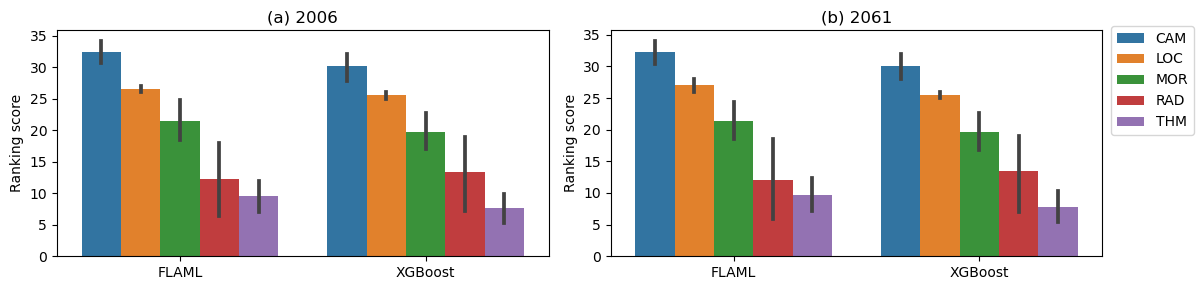

In [4]:
fig = plt.figure(figsize=(12,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "MOR", "RAD", "THM"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.2, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('./paper_figs/tree_importance_5.pdf', dpi=188)
plt.show()

## feature importance for surf

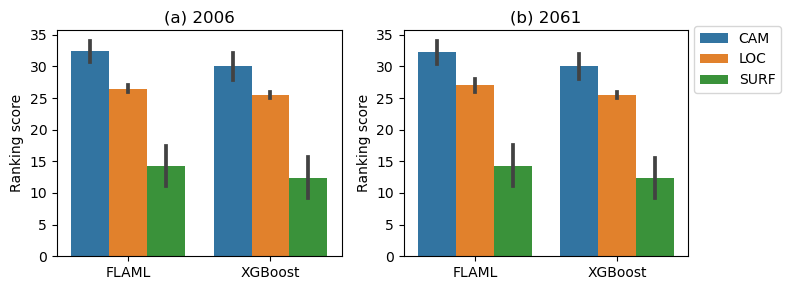

In [13]:
df = pd.read_csv("./data/feature_importance.csv").replace({"thermal":"SURF", "radiative":"SRUF", "morphological":"SURF"})
df = df.replace(["cam","loc","SURF"],["CAM", "LOC", "SURF"])
df_plot_tmp = df.set_index(["features","category"]).stack().reset_index()
df_plot_tmp.columns = ["features","category","model_year","ranking score"]

# split model_year
new = df_plot_tmp["model_year"].str.split("_", expand=True)
df_plot_tmp["model"] = new[0]
df_plot_tmp["year"] = new[1]
df_plot_tmp = df_plot_tmp.replace({"xgboost":"XGBoost"})
df_plot_tmp = df_plot_tmp[df_plot_tmp["model"]!="lgbm"]

df_plot = df_plot_tmp[["features","category","ranking score","model","year"]]


fig = plt.figure(figsize=(8,3))
(ax1, ax2) = fig.subplots(1,2)
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2006"], ax=ax1)
ax1.legend([],[],frameon=False)
ax1.set_title("(a) 2006")
ax1.set_ylabel("Ranking score")
ax1.set_xlabel("")
sns.barplot(x = "model", y = "ranking score", hue="category", 
            hue_order = ["CAM", "LOC", "SURF"],
            data = df_plot[df_plot["year"]=="2061"], ax=ax2)
ax2.legend(ncol=1, bbox_to_anchor=(1.35, 1.05))
ax2.set_title("(b) 2061")
ax2.set_ylabel("Ranking score")
ax2.set_xlabel("")
plt.tight_layout()
fig.savefig('./paper_figs/tree_importance_3.pdf', dpi=188)
plt.show()